# Operationalizer

**Variables to be operationalized**
- price in USD
- category variable
- ARF (market entry strategy) 
- market exit (deletion of account)
- ARM (time series)
- selling price adjustment (time series)
- proportion of negative feedbacks (time series)


In [1]:
import pandas as pd
import numpy as np

# plotting setup
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.dates as mdates

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from datetime import datetime
import os

from scipy import stats

## Silkroad2 Item Information

In [2]:
MAINDIR = os.getcwd().rsplit('/', 1)[0]
file = os.path.join(MAINDIR, 'data/final/silkroad2', 'items.pickle')

df = pd.read_pickle(file)

In [3]:
df = df\
    .assign(
        stime_str = pd.to_datetime(df['stime_str'], format = "%Y-%m-%d").dt.date.astype('datetime64'),
        stime_dt = pd.to_datetime(df['stime_str'], format = "%Y-%m-%d").dt.date.astype('datetime64'),
        reputation = df['vendor'].str.extract("([0-9]{2})$"),
        vendor = df['vendor'].str.replace("[0-9]{2}$", ""))\
    .assign(
        reputation = lambda x: x['reputation'].str.lstrip('0').apply(pd.to_numeric),
        rtime_dt = lambda x: x['stime_dt'] - pd.to_timedelta(x['freshness'], unit = 'd'))\
    .assign(
        reputation = lambda x: x['reputation'].where(x['reputation'] > 10, np.nan),
        flag = lambda x : x.rtime_dt.dt.date)

# store observation window
t_max = df['rtime_dt'].max()
t_min = df['rtime_dt'].min()

print(t_max, t_min)

2014-11-06 00:00:00 2013-11-22 00:00:00


In [4]:
# Assert that cases are unique
df = df.drop_duplicates(subset = ['feedback', 'item', 'rating', 'vendor', 'flag'])
df = df.drop('flag', axis = 1)

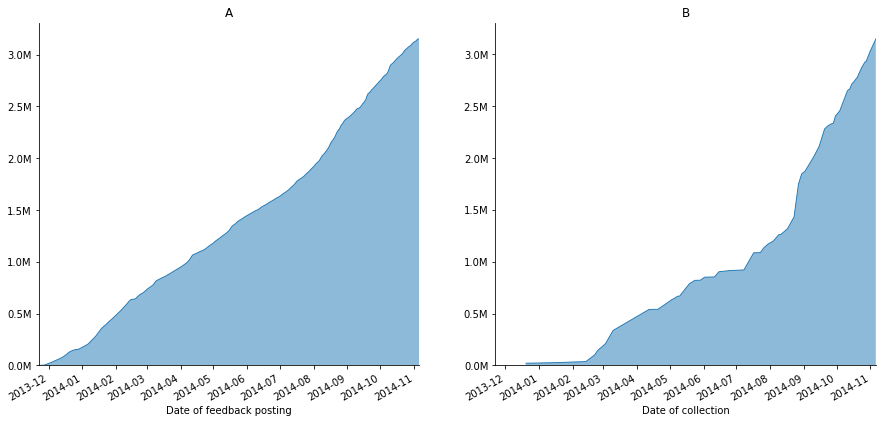

In [5]:
def millions(x, pos):
    return'{:,.1f}M'.format(x*1e-6)

# set outfile for image for report
outfile = os.path.join(MAINDIR, 'images', 'growth.pdf')

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 7))
fmt = mpl.ticker.FuncFormatter(millions)

#make cum_dist plot rating time (left)
df\
    .assign(rtime_dt = df['rtime_dt'].dt.date)\
    .groupby('rtime_dt')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax1, linewidth = .9)
ax1.set_ylim(bottom = 0)
ax1.yaxis.set_major_formatter(fmt)
ax1.set_xlim(t_min, t_max)
ax1.set_title('A')

#fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_xlabel('Date of feedback posting')


# make cum_dist plot scrape time (right)
df\
    .groupby('stime_dt')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax2, linewidth = .9)
ax2.set_ylim(bottom = 0)
ax2.yaxis.set_major_formatter(fmt)
ax2.set_xlim(t_min, t_max)
ax2.set_title('B')

#fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_xlabel('Date of collection')

fig.autofmt_xdate()
fig.savefig(outfile)
plt.show()

The plots above show the cumulative distribution of sample size by rating time (left: `rtime`) and scrape time (right: `stime`). 

#### Cumulative distribution of feedback postings
The left subplot show that the feedbacks posted in our sample are posted gradually over time. This reflects a natural growth distribution of feedback postings in the collected sample. This indicates that the scraping process of the data has proceeded quite reliably. 

#### Cumulative sample size make up per scrape
On the right subplot shows an increasing growth of sample size, which is an inherent characteristic of scraped data. Scrapes at later time points might collect data points that were overlooked in previous scrapes. 

In [6]:
s_max = df['stime_str'].max()
s_min = df['stime_str'].min()
s_frq = ((s_max - s_min) / len(df.stime_str.unique())).days

print("The data was collected once every {0} days between {1} and {2}"\
      .format(s_frq, s_min.strftime(format = "%B %d %Y"), s_max.strftime(format = "%B %d %Y")))
print("Within this timespan {0} unique transactions were observed, from a total of {1} unique sellers"\
      .format(len(df), len(df.vendor.unique())))

The data was collected once every 5 days between December 20 2013 and November 06 2014
Within this timespan 3151032 unique transactions were observed, from a total of 1232 unique sellers


In [7]:
drugs_trans = len(df.loc[df['category'].str.contains('drugs')])
total_trans = len(df)

drugs_vendor = df.loc[df['category'].str.contains('drugs')]['vendor'].nunique()
drugs_items = df.loc[df['category'].str.contains('drugs')]['item'].nunique()

print(drugs_trans, total_trans, drugs_trans/total_trans)
print(drugs_vendor, drugs_items)

2952596 3151032 0.9370250762289942
1221 28191


# Data Selection

In [8]:
# create time difference between sales for sellers
df = df.sort_values('rtime_dt')
df['t'] = df\
    .assign(rtime_dt = df['rtime_dt'])\
    .groupby('vendor')['rtime_dt']\
    .transform(lambda x: (x - x.min()).dt.days)


# creates time variables for sellers
df = df.sort_values(['vendor', 'rtime_dt'])
df['count'] = df.groupby(['vendor']).cumcount()
df = df.sort_values(['vendor', 'rtime_dt'])
df['cum_count'] = df.groupby('vendor')['vendor'].transform(np.size)

In [9]:
# drop vendors that have insufficient market activity
has_period = df\
    .groupby('vendor')['t']\
    .max()\
    .apply(lambda x: x > 14)

has_sales_volume = df\
    .groupby('vendor')['count']\
    .max()\
    .apply(lambda x: x > 20)

market_opening = df.rtime_dt.min()
df = df.sort_values(['vendor', 'rtime_dt'])
has_early_market_entry = df.groupby('vendor')\
    .apply(lambda x: (1 + (x.rtime_dt - market_opening).dt.days // 7))\
    .reset_index()\
    .groupby('vendor')['rtime_dt']\
    .min().apply(lambda x: x <=35)

In [10]:
# store initial sample 
N_ = df.shape[0]

# select cases
df = df\
    .loc[df['category'].str.contains('drugs')]

# store selected sample
N_drugs = df.shape[0]
k_drugs = df['vendor'].nunique()
  
# select seller with valid period and volume
df = df\
    .loc[(df['vendor'].map(has_period))\
         & (df['vendor'].map(has_sales_volume))
         & (df['vendor'].map(has_early_market_entry))]

N_final = df.shape[0]
k_final = df['vendor'].nunique()
p_final = df['item'].nunique()

print('Initial sample: ', N_, 
    '\nDrugs sample  : ', N_drugs,
    '\nDrugs sellers : ', k_drugs,
    '\nFinal:          ', N_final,
    '\nFinal sellers : ', k_final)

Initial sample:  3151032 
Drugs sample  :  2952596 
Drugs sellers :  1221 
Final:           2815399 
Final sellers :  925


In [11]:
p_final = df['item'].nunique()
p_final

24778

## Bitcoin Conversion information

In [12]:
# scrape Bitcoin data
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130429&end=20200212"

bitcoin_data = pd.read_html(url)[2]
bitcoin_data.columns =  map(str.lower, bitcoin_data.columns)

In [13]:
bitcoin_data = bitcoin_data[['date', 'open*', 'high', 'low', 'close**']]\
    .assign(date = pd.to_datetime(bitcoin_data['date']),
            mean = bitcoin_data[['high', 'low']].mean(axis=1))\
    .sort_values('date')\
    .reset_index(drop = True)

# define observation period
observation_period = (bitcoin_data['date'] > t_min)\
                      & (bitcoin_data['date'] < t_max)

max_bit = bitcoin_data[observation_period]['mean'].max()
min_bit = bitcoin_data[observation_period]['mean'].min()

In [14]:
bitcoin_data.head()

,date,open*,high,low,close**,mean
0,2013-04-29,134.44,147.49,134.00,144.54,140.745
1,2013-04-30,144.00,146.93,134.05,139.00,140.490
2,2013-05-01,139.00,139.89,107.72,116.99,123.805
3,2013-05-02,116.38,125.60,92.28,105.21,108.940
4,2013-05-03,106.25,108.13,79.10,97.75,93.615


### Fluctiations in bitcoin price

Bitcoin infamously known for its price flucuations. Although the window of observation of this study is way beyond the "bitcoin bubble" occured, there were considerable changes in bitcoin prices overtime.  {{max_bit}}

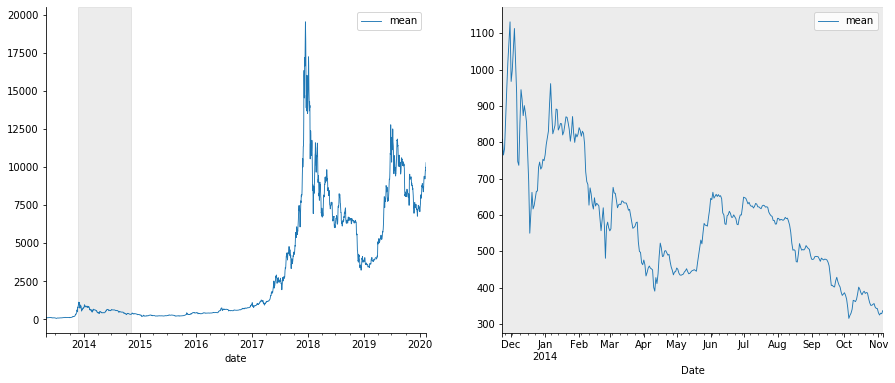

In [15]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 6))

# all time
bitcoin_data.plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax1
)

ax1.axvspan(t_min, t_max, color='grey', alpha=0.15)
ax2.set_xlabel('Date')

# time window of observations
bitcoin_data.loc[observation_period].plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax2
)

ax2.axvspan(t_min, t_max, color='grey', alpha=0.15)
ax2.set_xlabel('Date')

plt.show()

## Converting bitcoin to USD

To make the prices comparable over time points we convert te bitcoin prices to USD. 

In [16]:
# make covertion dictionary
rates = bitcoin_data\
    .assign(date = bitcoin_data['date'])\
    .set_index('date')['mean']\
    .to_dict()

# convert bitcoins to usd
df = df\
    .assign(price_usd = df['rtime_dt'].map(rates) * df['price'])

In [17]:
# assert values are not 'inf'
valid_range = (~df['price_usd'].isin([np.nan, np.inf, -np.inf]))\
               & (df['price_usd'] >= 0)

df['price_usd'] = df['price_usd'].mask(~valid_range)

# mark selling prices higher than 100000 as out of stock
df = df.assign(empty_stock = df['price_usd'] >= 10**4)

562


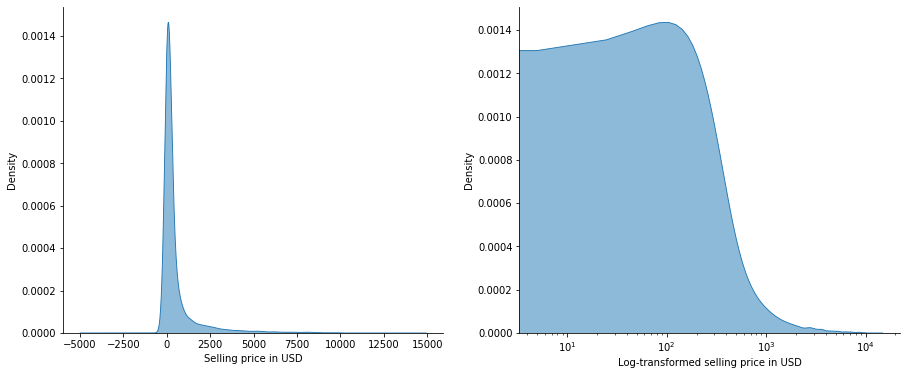

In [18]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

# plot not transformed price (right)
df['price_usd'][valid_range & (df['empty_stock'] == False)]\
    .sample(10000)\
    .dropna()\
    .plot.kde(linewidth = .9, ax = ax1)

# fill density plot (right)
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlabel('Selling price in USD')

# plot log transformed price (left)
df['price_usd'][valid_range & (df['empty_stock'] == False)]\
    .sample(10000)\
    .dropna()\
    .plot.kde(linewidth = .9, ax = ax2)

# fill density plot (left)
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set_xscale('log')
ax2.set_xlabel('Log-transformed selling price in USD')

# asses attriation due to invalid values
k_org = len(df['price_usd'][~df['price_usd'].isin([np.nan, np.inf, -np.inf])])
k_val = len(df['price_usd'][valid_range])
print(k_org - k_val)

plt.show()

The prices of products on *silkroad2* are extremely right skewed. Top tier prices range in USD +100,000. `log`-transformation helps to normalized selling prices considerably. Prices higher than USD 100,000 are considered outliers and are therefore excluded from the data. There by 24497 observations were coded as missing, which can be explained by: 
- missingness on the price variable
- `inf` value on the price value
- missingness on data value

## Rating Time

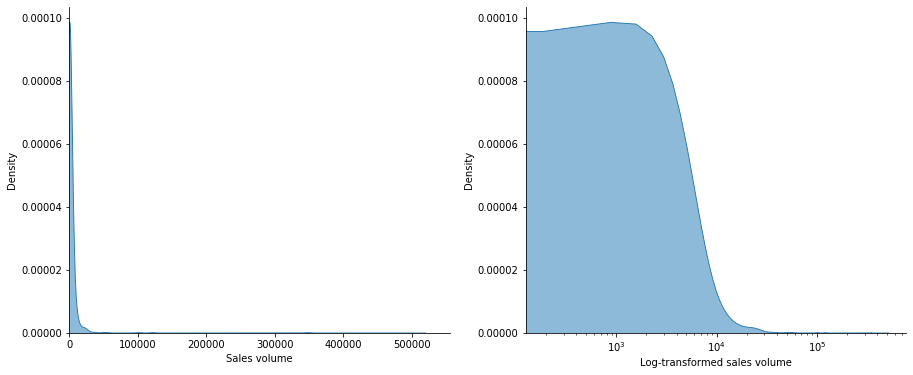

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# plots density distribution for sale volume (left)
df['vendor'].value_counts().plot.kde(ax = ax1, linewidth = .9)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = -50)
ax1.set(xlabel = 'Sales volume')

# plots density distribution for log-transformed sales volume (right)
df['vendor'].value_counts().plot.kde(ax = ax2, linewidth = .9)
ax2.set_xscale('log')

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set(xlabel = 'Log-transformed sales volume')

plt.show()

The graphs above displays the cumulative sales over time for each seller that had more than 20 sales in the observed period. The left panel displays the logmarithmically transformed sales trajectories over time. The right panel shows the proportional increase in sales over the proportion of time that the seller as pressent on the market. 

## Artificial Reputation Formation

In [20]:
def f(x):
    x['diff'] = x['t']-x['t'].shift(1)
    return x

df = df.sort_values(['vendor', 't'])

# calculates time difference between sales
df['diff'] = df\
    .groupby('vendor')\
    .apply(f)['diff']\
    .fillna(1)\
    .sort_index()

# drop existing column
if 'delta_t' in df:
    df = df.drop('delta_t', axis = 1)

# creates look-up table with delta_t column
df = df.sort_values(['vendor', 't'])
col = df['diff']\
    .groupby([df['vendor'], df['t']])\
    .apply(lambda x: x.mean())\
    .reset_index()\
    .rename(columns = {'diff' : 'delta_t'})
    
# merges delta_t on dataframe
df = pd.merge(df, col, on = ['vendor', 't'])

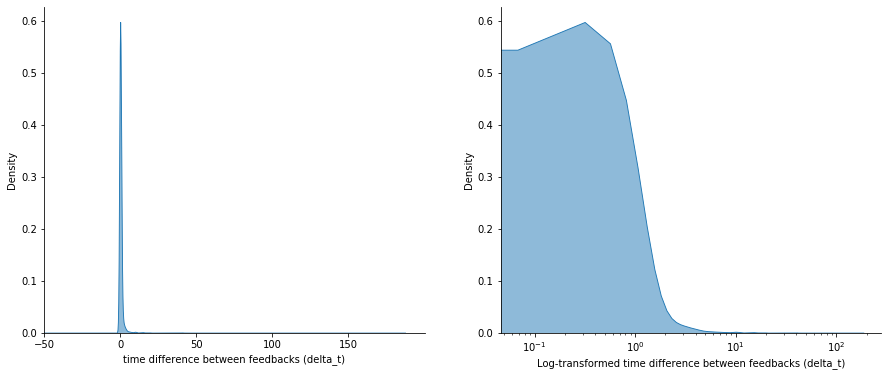

In [21]:
market_entry = (df['count'] <= 10) & (df['empty_stock'] == False)

# set plotting areas
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# make distribution plot w/o transformation (left)
df[market_entry]['delta_t'].plot.kde(ax = ax1, linewidth = .9)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# set axes
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = -50)
ax1.set(xlabel = 'time difference between feedbacks (delta_t)')

# make distribution plot with log transformation (right)
df[market_entry]['delta_t'].plot.kde(ax = ax2, linewidth = .9)
ax2.set_xscale('log')

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# set axes
ax2.set_ylim(bottom = 0)
ax2.set(xlabel = 'Log-transformed time difference between feedbacks (delta_t)')

plt.show()

The plots above present the density distributions of time difference between posted feedbacks. As expected, these distributions are extremely left skewed. **cut-off values need to be determined to excluded univariate outliers**

### Visual inspection of temporal fluctuation in cut-offs

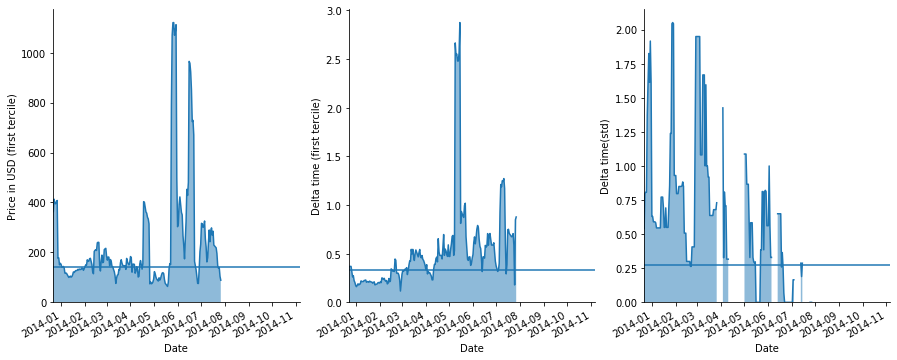

In [22]:
# setting cut of values
t_cut = df[market_entry]['delta_t'].quantile(1/2)
p_cut = df[market_entry]['price_usd'].quantile(1/2)
s_cut = df[market_entry].groupby('vendor')['delta_t'].std().quantile(1/2)

# offset minimum time
nt_min = t_min + pd.DateOffset(days = 30)

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = [15,6])

# plot price fluctuation over time (left)
df[market_entry]\
    .groupby(df['rtime_dt'].dt.date)['price_usd']\
    .quantile(1/2)\
    .rolling(7, center = True)\
    .mean().plot(ax = ax1)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal lines
ax1.axhline(y = p_cut)

# set axes
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = nt_min, right = t_max)
ax1.set(xlabel = 'Date',
        ylabel = 'Price in USD (first tercile)')

# plot delta_t fluctuations over time (middle)
df[market_entry]\
    .groupby(df['rtime_dt'].dt.date)['delta_t']\
    .quantile(1/3)\
    .rolling(7, center = True)\
    .mean().plot(ax = ax2)

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal line
ax2.axhline(y = t_cut)

# set axes
ax2.set_ylim(bottom = 0)
ax2.set_xlim(left = nt_min, right = t_max)
ax2.set(xlabel = 'Date',
        ylabel = 'Delta time (first tercile)')

# plot delta_t fluctuations over time (middle)
df[market_entry]\
    .groupby(df['rtime_dt'].dt.normalize())['delta_t']\
    .std()\
    .rolling(7, center = True)\
    .quantile(1/3).plot(ax = ax3)

# fill graph
line = ax3.lines[0].get_data()
ax3.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal line
ax3.axhline(y = s_cut)

# set axes
ax3.set_ylim(bottom = 0)
ax3.set_xlim(left = nt_min, right = t_max)
ax3.set(xlabel = 'Date',
        ylabel = 'Delta time(std)')

fig.autofmt_xdate()
plt.show()

### Decision Rule for ARF

In [23]:
# drop existing column
if 'arf' in df: 
    df = df.drop('arf', axis = 1)

# ARF 1
col = df[market_entry]\
    .groupby('vendor')\
    .apply(lambda x: (x['delta_t'].mean() < t_cut\
                      and (x['price_usd'].mean() < p_cut)\
                      and (x['delta_t'].std() < s_cut)))\
    .rename('arf')

df = df.merge(col, on = 'vendor')

In [24]:
names = ['s_cut(entry)', 't_cut(entry)', 'p_cut(entry)']
cuts  = [ s_cut,   t_cut,   p_cut]

for n, c in zip(names, cuts):
    print(n, round(c, 3))

s_cut(entry) 0.271
t_cut(entry) 0.333
p_cut(entry) 139.695


In [25]:
len(df[df['arf'] == True]['vendor'].unique())

103

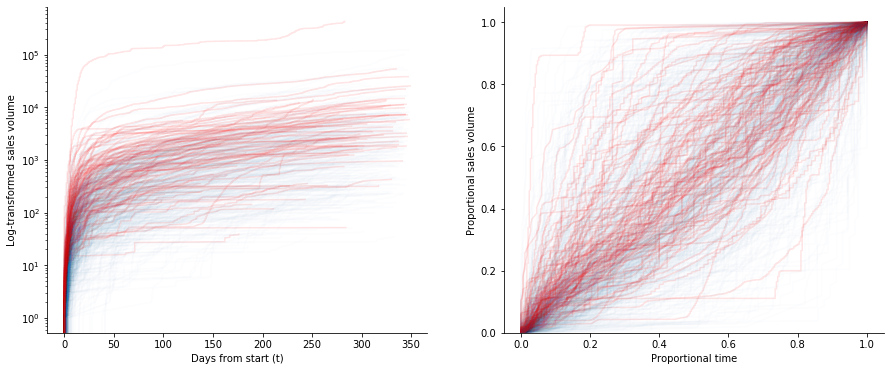

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]

vendors = df_['vendor'].unique().tolist()
colors = {True  : 'red',
          False : '#1f77b4'}
alphas = {True  : .10,
          False : .01}

# iterative plotting for sales trajectory of cryptosellers
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't', 'arf']].dropna()
    y = v['count'].astype(int).sort_values()
    x = v['t'].astype(int).sort_values()
    c = v['arf'].map(colors).to_list()[0]
    a = v['arf'].map(alphas).to_list()[0]
    
    # Plots sales trajectory 
    ax1.plot(x, y, alpha = a, c = c)
    ax1.set_yscale('log')
    ax1.set(xlabel = 'Days from start (t)',
            ylabel = 'Log-transformed sales volume')
    
    y = y / v['count'].max()
    x = x / v['t'].max()
    
    # Plots proportional sales trajectory
    ax2.plot(x, y, alpha = a, c = c)
    ax2.set_ylim(bottom = 0)
    ax2.set(xlabel = 'Proportional time',
            ylabel = 'Proportional sales volume')

# display plot
plt.show()

## Negative Ratings

In [27]:
(df['rating'] == 5).mean()

0.9715459813520503

In [28]:
df = df.sort_values(['vendor','count']).reset_index(drop = True)

# cumulative count of negative feedbacks per vendor
df['neg_count'] = df\
    .assign(neg = df['rating'] != 5)\
    .groupby('vendor')['neg']\
    .cumsum()\
    .reset_index(drop = True)\
    .rename('neg_count') + 1

df = df.sort_values(['vendor','count']).reset_index(drop = True)
# cumulative count of positive feedbacks per vendor
df['pos_count'] = df\
    .assign(pos = df['rating'] == 5)\
    .groupby('vendor')['pos']\
    .cumsum()\
    .reset_index(drop = True)\
    .rename('pos_count') + 1

In [29]:
# cumulative proportion of negative feedbacks per vendor
df['neg_rating'] = df['neg_count'] / (df['count'] + 1)

## Control Variables

### Ships internationally

In [30]:
df = df\
    .assign(
        location = df['location'].replace('unknown', 'Undeclared').astype('category'),
        area = df['area'].replace('unknown', 'Undeclared').astype('category'))

df['international_shipment'] = df['location'].astype(str) != df['area'].astype(str)

### Category

In [31]:
cat = df['category'].str.lower()\
    .str.replace('drugs-', '')\
    .str.replace('intoxicants-', '')

In [32]:
cat.loc[cat.str.count('-') == 0 & cat.str.contains('drugs')] = 'unknown-unknown-unclassified'
cat[cat.str.count('-') == 1] = cat[cat.str.count('-') == 1] + '-unclassified'
cat[cat.str.count('-') >= 3] = cat[cat.str.count('-') >= 3].str.split('-').apply(lambda x: '-'.join(x[0:3]))

In [33]:
map_dict = {
    'prescription-opioids': 'opioids-prescription',
    'prescription-stimulants': 'stimulants-prescription',
    'other-ghb': 'dissociatives-ghb',
    'other-gbl': 'dissociatives-gbl',
    'other-alcohol': 'alcohol-alcohol',
    'other-tobacco' : 'tobacco-tobacco',
    'stimulants-mephedrone': 'ecstasy-mephedrone',
    'stimulants-ephedrine-unclassified' : 'stimulants-prescription-ephedrine',
    'stimulants-ethylphenidate-unclassified': 'stimulants-prescription-ethylphenidate',
    'stimulants-dimethocaine-unclassified': 'stimulants-prescription-dimethocaine',
    'prescription-analgesics-unclassified': 'opioids-prescription-painkillers',
    'prescription-analgesics-oxycodone': 'opioids-prescription-oxycodone',
    'prescription-analgesics': 'opioids-prescription'
}

for key in map_dict.keys():
    cat = cat.str.replace(key, map_dict[key])

In [34]:
categories = pd.DataFrame()
categories[['category', 'sub_category', 'product_group']] = pd.DataFrame([ x.split('-') for x in cat.tolist()])

In [35]:
# recoding subgroups for cannabis
map_dict = {
    'pre': 'weed',
    'concentrates': 'product',
    'edibles': 'product',
    'shake': 'product',
    'trim': 'other',
    'synthetic' : 'product',
    'seeds': 'other',
    'clones': 'other',
    'cuttings': 'other'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'cannabis','sub_category']\
    = categories.loc[
        categories['category'] == 'cannabis','sub_category']\
    .replace(key, map_dict[key])

In [36]:
# recoding subgroups for stimulants
map_dict = {
    '6apb': 'designer',
    '5apb': 'designer',
    'fas' : 'other', 
    'pentedrone': 'designer', 
    '4mec': 'designer', 
    'fmas': 'designer', 
    'apvp': 'designer',
    'mdppp': 'designer', 
    'mdpv': 'designer', 
    'fmcs': 'designer', 
    '2dpmp': 'designer',
    '4emc': 'designer',
    'speed': 'amphetamine',
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'stimulants','sub_category']\
    = categories.loc[
        categories['category'] == 'stimulants','sub_category']\
    .replace(key, map_dict[key])

In [37]:
# recoding subgroups for dissociatives
map_dict = {
    'ghb': 'ghb_gbl',
    'gbl': 'ghb_gbl',
    'pcp': 'other',
    'mxe': 'other'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'dissociatives','sub_category']\
    = categories.loc[
        categories['category'] == 'dissociatives','sub_category']\
    .replace(key, map_dict[key])

In [38]:
# recoding subgroups for ecstasy
map_dict = {
    'butylone': 'other',
    'pentedrone': 'designer',
    'methylone': 'other',
    'mda': 'other',
    'mpa': 'designer',
    'mdai': 'designer',
    'ethylone': 'designer'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'ecstasy','sub_category']\
    = categories.loc[
        categories['category'] == 'ecstasy','sub_category']\
    .replace(key, map_dict[key])

In [39]:
# recoding subgroups for psychedelics
map_dict = {
    '2cfamily': 'other', 
    'dmt': 'other', 
    '4acofamily': 'other', 
    'nbome': 'other', 
    'entheogens': 'other', 
    'dox': 'other', 
    'allad': 'other', 
    'lsz': 'lsd', 
    '5meofamily': 'other', 
    'salvia': 'other', 
    '4hofamily': 'other', 
    'lsa': 'lsd', 
    'dpt': 'other', 
    'amt': 'other',
    'shrooms': 'mushrooms'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'psychedelics','sub_category']\
    = categories.loc[
        categories['category'] == 'psychedelics','sub_category']\
    .replace(key, map_dict[key])

In [40]:
# recoding subgroups for prescription
map_dict = {
    'sildenafilcitrate': 'other',
    'generalhealth': 'other',
    'antidepressant': 'other',
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'prescription','sub_category']\
    = categories.loc[
        categories['category'] == 'prescription','sub_category']\
    .replace(key, map_dict[key])

In [41]:
# recoding subgroups for opioids
map_dict = {
    'opioids': 'other',
    'opium': 'other',
    'kratom': 'other',
    'ah': 'other'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'opioids','sub_category']\
    = categories.loc[
        categories['category'] == 'opioids','sub_category']\
    .replace(key, map_dict[key])

In [42]:
# ensure rightly coded sub_categories and product_groups
categories.loc[categories['product_group'] == 'benzos', 'category'] = 'Benzodiazepam'
categories.loc[categories['product_group'] == 'oxycodone', 'sub_category'] = 'oxycodone'
categories.loc[categories['product_group'] == 'amphetamine', 'sub_category'] = 'amphetamine'
categories.loc[categories['sub_category']  == 'amphetamine', 'category'] = 'stimulants'

categories = categories.astype({
    'category': 'category',
    'sub_category' : 'category'
})

In [43]:
if 'category' in df: 
    df = df.drop('category', axis = 1)

if 'sub_category' in df: 
    df = df.drop('sub_category', axis = 1)

df = pd.concat([df, categories[['category', 'sub_category']]], axis = 1)

# Aggregation (Vendor > Item > Week)

In [51]:
f_df = df.loc[df['count'] > 10].copy()

In [52]:
f_df = f_df\
    .drop(['stime', 'stime_dt', 'stime_str', 'feedback',
           'freshness', 'rtime', 'location', 'area'], axis = 1)\
    .assign(vendor = f_df['vendor'].factorize()[0] + 1,
            item   = f_df['item'].factorize()[0] + 1,
            rating = f_df['rating'].astype(int),
            count = f_df['count'] - 10,
            w = (f_df.t + 1).astype('timedelta64[D]') // pd.Timedelta(days = 7) + 1)\
    .reset_index(drop = True)

In [53]:
item_count = f_df['item']\
    .groupby(f_df['vendor'])\
    .nunique()\
    .rename('item_count')

f_df = f_df.merge(item_count, on = 'vendor')

item_count = f_df['item']\
    .groupby([f_df['vendor'], f_df['w']])\
    .nunique()\
    .rename('item_count_w')

f_df = f_df.merge(item_count, on = ['vendor', 'w'])

In [54]:
category_count = f_df['category']\
    .groupby(f_df['vendor'])\
    .nunique()\
    .rename('category_count')

f_df = f_df.merge(category_count, on = 'vendor')

category_count = f_df['category']\
    .groupby([f_df['vendor'], f_df['w']])\
    .nunique()\
    .rename('category_count_w')

f_df = f_df.merge(category_count, on = ['vendor', 'w'])

In [55]:
outfile = os.path.join(MAINDIR, 'data/analysis', 'vendor_item_period.csv')
f_df.to_csv(outfile)

In [56]:
select = {
    'mean': {
        'rows': ['rating', 'reputation', 'price_usd', 'delta_t',
                 'neg_rating'],
        'func': np.mean,
        'suff': '_m'},
    
    'min': {
        'rows': ['count', 'neg_count', 'pos_count', 'rtime_dt'],
        'func': np.min,
        'suff': '_min'},
    
    'std': {
        'rows': ['price_usd', 'delta_t'],
        'func': np.std,
        'suff': '_s'},
    
    'fixed': {
        'rows': ['cum_count', 'arf', 
                'international_shipment', 'item_count',
                'item_count_w', 'category_count', 'category_count_w'],
        'func': np.max,
        'suff': ''},
}

levels = ['vendor', 'item', 'w']

def aggregate_data(df = f_df, levels = levels, select = select):
    # mutate columns with corresponding functions
    container = []
    for key in select.keys():
        container.append(
            df.groupby(levels)\
                [select[key]['rows']]\
                .agg(select[key]['func'])\
                .fillna(0)
                .add_suffix(select[key]['suff']))

    # concatinate mutated columns
    data = pd.concat(container, axis = 1).reset_index()
    
    return data
    
data = aggregate_data()

### Drop in selling prices

In [57]:
# make price_diff on aggregated data
data['price_diff'] = data\
    .groupby(['vendor', 'item'])\
    .apply(lambda x: ((x['price_usd_m'] / x['price_usd_m'].shift(1))))\
    .reset_index(drop = True)\
    .fillna(1)\

In [58]:
# make empty_stock_yesterday on aggregated data
data['empty_stock_last_week'] = data\
    .assign(empty_stock = data['price_usd_m'] > 10**4)\
    .groupby(['vendor', 'item'])['empty_stock']\
    .apply(lambda x: x.shift(1))\
    .fillna(False)

# make has_price_drop on aggregated data
data.loc[data['empty_stock_last_week'], 'price_diff'] = None

In [59]:
# weeks after market opening
data = data.sort_values(['vendor', 'rtime_dt_min'])
data = data.assign(
    me = 1 + (data['rtime_dt_min'] - market_opening).dt.days // 7)

In [60]:
data.groupby('vendor')['me'].min().unique()

array([ 2,  8, 12, 11,  5,  7,  4, 15, 30, 14,  3,  1,  9, 24, 10,  6, 16,
       17, 22, 34, 18, 36, 32, 27, 13, 19, 20, 21, 38, 31, 28, 35, 25, 23,
       33, 29, 26])

## ARM 

In [61]:
# cut offs
t_cut = data['delta_t_m'].quantile(1/2)
p_cut = data['price_usd_m'].quantile(1/2)
s_cut = data['delta_t_s'].quantile(1/2)

# make ARM variable
data['arm'] = data\
    .assign(t_low = lambda x: x['delta_t_m'] < t_cut,
            p_low = lambda x: x['price_usd_m'] < p_cut,
            s_low = lambda x: x['delta_t_s'] < s_cut)\
    .assign(arm = lambda x: (x[['t_low', 'p_low', 's_low']].all(axis = 1)))['arm']

# Aggregation (Vendor > Week)

In [62]:
select = {
    'mean': {
        'cols': ['rating', 'reputation', 'price_usd', 'delta_t',
                 'neg_rating'],
        'func': np.mean,
        'suff': '_m'},
    
    'min': {
        'cols': ['count', 'neg_count', 'pos_count'],
        'func': np.min,
        'suff': '_min'},
    
    'std': {
        'cols': ['price_usd', 'delta_t'],
        'func': np.std,
        'suff': '_s'},
    
    'fixed': {
        'cols': ['cum_count', 'arf', 
                'neg_rating', 'international_shipment', 'item_count',
                'item_count_w', 'category_count', 'category_count_w'],
        'func': np.max,
        'suff': ''},
    
    # aggregate to vendor_week level data      
    'mean_w': {
        'cols': ['price_diff'],
        'func': np.mean, 
        'suff': '_mw'},
    
    'max_w': {
        'cols': ['arm', 'empty_stock_last_week'],
        'func': np.max, 
        'suff': '_maxw'},
    
    'min_w': {
        'cols': ['me'],
        'func': np.min, 
        'suff': '_min'},
    
    'count_w': {
        'cols': ['empty_stock_last_week', 'international_shipment'],
        'func': np.sum, 
        'suff': '_count_w'}
}

levels = ['vendor', 'w']

def aggregate_data(dfs = [f_df, data], levels = levels, select = select):
    # mutate columns with corresponding functions
    container = []
    for key in select.keys():
        if (key is not 'mean_w') & (key is not 'max_w')\
            & (key is not 'min_w') & (key is not 'count_w'):
            container.append(
                dfs[0].groupby(levels)\
                    [select[key]['cols']]\
                    .agg(select[key]['func'])\
                    .fillna(0)
                    .add_suffix(select[key]['suff']))
        else: 
            container.append(
                dfs[1].groupby(levels)\
                    [select[key]['cols']]\
                    .agg(select[key]['func'])\
                    .fillna(0)
                    .add_suffix(select[key]['suff']))
            

    # concatinate mutated columns
    data = pd.concat(container, axis = 1).reset_index()
    
    return data
    
vendor_week = aggregate_data()

In [63]:
vendor_week = vendor_week.sort_values(['vendor', 'w'])

vendor_week['neg_count_w'] = vendor_week\
    .groupby('vendor')\
    .apply(lambda x:  x['neg_count_min'] - x['neg_count_min'].shift(1))\
    .reset_index(drop = True)\
    .fillna(vendor_week['neg_count_min'])

vendor_week['pos_count_w'] = vendor_week\
    .groupby('vendor')\
    .apply(lambda x:  x['pos_count_min'] - x['pos_count_min'].shift(1))\
    .reset_index(drop = True)\
    .fillna(vendor_week['pos_count_min'])

### Lowering of Selling Prices

In [64]:
diff_cut = vendor_week.loc[vendor_week['price_diff_mw'] > 0\
                & (~vendor_week['price_diff_mw'].isin([np.inf, -np.inf])), 
                'price_diff_mw'].quantile(.10)

price_diff = vendor_week.loc[vendor_week['price_diff_mw'] > 0\
                & (~vendor_week['price_diff_mw'].isin([np.inf, -np.inf])), 
                'price_diff_mw']

In [65]:
vendor_week.loc[vendor_week['price_diff_mw'] > 0\
                & (~vendor_week['price_diff_mw'].isin([np.inf, -np.inf])), 
                'has_price_drop']\
    = price_diff < diff_cut

vendor_week['has_price_drop'] = vendor_week['has_price_drop'].fillna(False)

In [66]:
vendor_week.loc[vendor_week['price_diff_mw'].isin([np.inf]), 'price_diff_mw'] = None
vendor_week['sales_volume_w'] = vendor_week.groupby('vendor').apply(lambda x: x['count_min'] - x['count_min'].shift(1)).reset_index(drop = True)

# Shift Dependent variables with one week 
for col in ['has_price_drop', 'arm_maxw', 'neg_count_w', 'pos_count_w']: 
    vendor_week['{0}_shift'.format(col)] = vendor_week\
        .groupby('vendor')\
        .apply(lambda x: x[col].shift(1))\
        .reset_index(drop = True)\

shift = ['has_price_drop_shift', 'arm_maxw_shift', 'neg_count_w_shift', 'pos_count_w']
vendor_week = vendor_week.dropna(subset = shift).reset_index(drop = True)

# Data Summary

In [67]:
vendor_week\
    [['arm_maxw', 'has_price_drop', 'neg_count_w', 'pos_count_w',
      'item_count_w', 'international_shipment_count_w',
      'international_shipment', 'w']]\
    .astype({'has_price_drop': int,
             'arm_maxw': int,
             'international_shipment': int})\
    .describe()\
    .applymap('{:.3f}'.format)\
    .T[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
arm_maxw,22777.000,0.146,0.354,0.000,1.000
has_price_drop,22777.000,0.104,0.305,0.000,1.000
neg_count_w,22777.000,3.339,17.943,0.000,869.000
pos_count_w,22777.000,115.027,554.817,0.000,34817.000
item_count_w,22777.000,12.837,31.916,1.000,628.000
international_shipment_count_w,22777.000,9.755,32.066,0.000,628.000
international_shipment,22777.000,0.638,0.481,0.000,1.000
w,22777.000,20.587,12.729,2.000,51.000


In [68]:
vendor_week\
    [['vendor', 'arf', 'category_count', 'me_min']]\
    .astype({'arf' : int})\
    .groupby('vendor')\
    .mean()\
    .describe()\
    .applymap('{:.3f}'.format)\
    .T[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
arf,902.000,0.114,0.318,0.000,1.000
category_count,902.000,3.278,1.817,1.000,10.000
me_min,902.000,23.481,8.223,3.000,44.500


# Export File

In [69]:
vendor_week.to_pickle(os.path.join(MAINDIR, 'data/final/silkroad2', 'vendor_week.pickle'))
vendor_week.replace([True, False], [1, 0]).to_csv(os.path.join(MAINDIR, 'data/final/silkroad2', 'vendor_week.csv'))